# Sentence classification

Multilingual Natural Language Processing 2024

Authors: Tommaso Bonomo, Luca Moroni

In [2]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [4]:
### Imports ###
import json
from pathlib import Path
from collections import Counter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pack_padded_sequence

/home/matteo/AI and Robotics/NLP/HM1b/.venv/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/matteo/AI and Robotics/NLP/HM1b/.venv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/matteo/AI and Robotics/NLP/HM1b/.venv/lib/python3.12/site-packages/torchtext/

# Task definition

We define as *text classification* the class of tasks where a single label is associated to a sentence.
The most common task that fits this description is **Sentiment Analysis**: given a sentence, a model should predict it's sentiment across a number of classes.

In this notebook we will focus on the Stanford Sentiment Treebank corpus, specifically the sentiment classification binary task, where each sentence must be classified as having either positive (1) or negative (0) sentiment.

Here are a couple of examples:

| Sentence | Sentiment |
|----------|-----------|
| saw how bad this movie was | negative |
|the greatest musicians | positive |
| cold movie | negative |
| equals the original and in some ways even betters it | positive |
| ... | ... |

# Data preparation

We have prepared the SST2 dataset for you at [this repository](http://github.com/tommasobonomo/nlp2024-hw1b). The following cells will extract the needed files in a local folder.

In [ ]:
!git clone https://github.com/SapienzaNLP/nlp2024

fatal: destination path 'nlp2024' already exists and is not an empty directory.


In [ ]:
train_path = Path("nlp2024/notebook4_extra/data/train.jsonl")
validation_path = Path("nlp2024/notebook4_extra/data/validate.jsonl")
test_path = Path("nlp2024/notebook4_extra/data/test.jsonl")

As you can see, each split is saved in a JSONL file: each line of the file is a JSON object representing a sample of the dataset. Here's an example of what each sample looks like:

In [ ]:
!head nlp2024/notebook4_extra/data/validate.jsonl

{"idx":1736,"sentence":"a low-budget series on a uhf channel ","label":0}
{"idx":59242,"sentence":"showtime 's uninspired send-up ","label":0}
{"idx":27031,"sentence":"it 's difficult to shrug off the annoyance of that chatty fish ","label":0}
{"idx":63438,"sentence":"cold ","label":0}
{"idx":60085,"sentence":"the film is a hilarious adventure and i shamelessly enjoyed it . ","label":1}
{"idx":64415,"sentence":"naturalistic ","label":1}
{"idx":12067,"sentence":"he 's well worth spending some time with ","label":1}
{"idx":24528,"sentence":"the metaphors are provocative , but too often , the viewer is left puzzled by the mechanics of the delivery ","label":0}
{"idx":52294,"sentence":"grows decidedly flimsier with its many out-sized , out of character and logically porous action set pieces ","label":0}
{"idx":9377,"sentence":") just too bratty for sympathy ","label":0}


And we can quickly verify how many samples are in each split. We took 10% of the original training file to use as a validation set. There should be 67349 samples for training and validation and 872 for testing.

In [ ]:
def count_lines(path: Path) -> int:
    with open(path, "rb") as f:
        return sum(1 for _ in f)
assert count_lines(train_path) + count_lines(validation_path) == 67349
count_lines(train_path), count_lines(validation_path), count_lines(test_path)

(60614, 6735, 872)

In this dataset, we have complete sentences and not single tokens. This means we have to perform the tokenization operation ourselves.

For this notebook, we will use the basic English tokenizer provided within the `torchtext.data.utils.get_tokenizer`, which normalizes the sentences through some simple rules and splits tokens based on whitespace. We will integrate this tokenizer directly into our dataset class, but here is an example of how it works:

In [5]:
tokenizer = get_tokenizer("basic_english")
tokenizer("This movie was the best of my life!")

['this', 'movie', 'was', 'the', 'best', 'of', 'my', 'life', '!']

The following `SST2Dataset` subclass of `torch.data.Dataset` represents our dataset tokenized with the basic English tokenizer from TorchText. Feel free to explore and use other tokenizers if you feel like it!

It also implements a method to build the vocabulary and a `_collate_fn` to be used within a `torch.utils.data.Dataloader` object. This is the usual way to process data in the PyTorch framework. The collate function takes a list of samples, each one obtained through the `__getindex__` function, and collates them together (aka gather and organizes them) to form a batch. Check out the [dedicated section](https://pytorch.org/docs/stable/data.html#working-with-collate-fn) in the PyTorch documentation.

In this case, we will use the utility function `pad_sequence` from `torch.utils.rnn` to pad each sentence to a common length, truncating to a predetermined `max_length`. Further information can be found in the [official documentation](https://pytorch.org/docs/stable/data.html).

In [ ]:
class SST2Dataset(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 1028,
        device: str = "cuda"
    ):
        # Get simple basic English tokenizer
        tokenizer = get_tokenizer("basic_english")

        # Save samples from input file
        self.samples = []
        with open(input_file, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                # the sample dictionary contains the following key: idx, sentence and label (integer)
                sample["tokens"] = tokenizer(sample["sentence"])
                self.samples.append(sample)

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        # each dictionary represents a sentence with two keys: "input_ids" and "label"
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # Keep track of padding id
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        """Utility function that gets the raw sample corresponding to `idx`."""
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        """Builds a `torchtext.vocab.Vocab` object from data stored in this object."""
        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
        # We build the vocabulary through a dictionary like {token: frequency, ...}
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        # vocabulary(list of tokens) returns a list of values, so get the only one
        vocabulary.set_default_index(vocabulary([unk_token])[0])
        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        """Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`"""
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                # append the dictionary containing ids of the input tokens and label
                indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Batches together single elements of the dataset.
        This function:
        - converts each sentence made up of single input_ids to a padded tensor,
        - keeps track of the length of each sentence through `sequence_lengths`
        - builds a `labels` tensor storing the label for each sentence

        Args:
            raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.

        Returns:
            A tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
        """
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

# Modelling

We will stick with the same architecture introduced in [Notebook #4](https://https://colab.research.google.com/drive/1Z4ogGO58owxu0e9-hbUtjJYqud3OuJ1H), i.e. a simple BiLSTM architecture on the input sequence.

We will then apply a simple feed-forward layer to the last hidden state to classify the whole sentence as either positive or negative.

But we also need to map each token to an embedding through an Embedding layer.


![](https://www.researchgate.net/publication/336899835/figure/fig2/AS:819722442518530@1572448468976/Sequence-to-Label-classification-using-LSTM-NN.jpg)


## Handling padding tokens

Our Dataset class return a Tensor (batch) for every training step. Each sentence present in the batch must have the same length, so the padding token is added to fill missing tokens.

![](https://juditacs.github.io/assets/padded_sequence.png)

We need to avoid the error computation (gradient flow) to go through the input's padding tokens. To do so, in PyTorch, you can use `pack_padded_sequence` ([doc](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html)) from `torch.utils.rnn`, a function that removes the padding tokens from the input and gives to the model only the relevant tokens. It does so by keeping in memory two tensors, 1) the flattened element sequence, 2) the batch sizes at each time step (which is dynamically updated at each timestep, based on the sequence lengths). For instance:

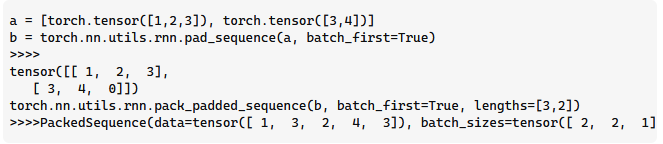

In [ ]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )

        # Feel free to modify and change any hyperparameters or architectural details

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padding tokens.
        # An alternative to packing sequences is using masking.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H], where the 2 is because we are using BiLSTMs instead of LSTMs.
        # cell_state has size [2 * num_layers, B, C] where C is the cell dimension of the internal LSTMCell.
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
        # layer's is backward) by concatenating forward and backward over dimension 1.
        # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
        # tensor of shape [B, 2 * H]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden) # [B, 2]
        return logits

# Trainer

As in [Notebook #4](https://https://colab.research.google.com/drive/1Z4ogGO58owxu0e9-hbUtjJYqud3OuJ1H), we construct a `Trainer` utility class to help us with training our model.
It defines the following main ingredients for model training:

*   A **training loop** that iterates over a set of training examples that are used by the model to learn to solve our task.
*   An **evaluation function** to evaluate the learning progress of our model.
*   A **prediction function** to actually obtain the output of the model.

In order to correctly learn, our model needs a *loss function* to determine how far the output of our model is from what it should have been, and an *optimizer* to "correct" the model internal weights based on the value of the loss function. We pre-determine the loss function directly in this class to use the standard `torch.nn.CrossEntropyLoss` function.



In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the BiLSTM model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.
        predictions = torch.argmax(logits, dim=1)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        # which averaged gives an accuracy of 4/5, i.e. 0.80.
        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels = batch

                logits = self.model((sequence_lengths, inputs))

                # Same considerations as the training step apply here
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()

                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader),

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions

We just need to define our datasets...

In [ ]:
pad_token, unk_token = "<pad>", "<unk>"
device = "cuda"

train_dataset = SST2Dataset(train_path, device=device)
validation_dataset = SST2Dataset(validation_path, device=device)
test_dataset = SST2Dataset(test_path, device=device)

vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary([pad_token])[0]

train_dataset.set_padding_id(padding_id)
validation_dataset.set_padding_id(padding_id)
test_dataset.set_padding_id(padding_id)

train_dataset.index(vocabulary)
validation_dataset.index(vocabulary)
test_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(validation_dataset)}")
print(f"Test len: {len(test_dataset)}")

training_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=False, collate_fn=validation_dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=test_dataset._collate_fn)

sentiment_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=64,
    bilstm_layers=2,
    bilstm_dropout=0.3,
    num_classes=2,
    padding_id=padding_id,
    device=device
)

Training len: 60614
Validation len: 6735
Test len: 872


... setup a Trainer, and ...

In [ ]:
trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=0.0001),
    log_steps=100
)

... train our model.

In [ ]:
losses = trainer.train(training_dataloader, validation_dataloader, epochs=10)

Training ...
 Epoch  1
	[E:  1 @ step 99] current avg loss = 0.6866
	[E:  1 @ step 199] current avg loss = 0.6838
	[E:  1 @ step 299] current avg loss = 0.6805
	[E:  1 @ step 399] current avg loss = 0.6752
	[E:  1] train loss = 0.6701
  [E:  1] valid loss = 0.6468, valid acc = 0.6196
 Epoch  2
	[E:  2 @ step 99] current avg loss = 0.6270
	[E:  2 @ step 199] current avg loss = 0.6222
	[E:  2 @ step 299] current avg loss = 0.6169
	[E:  2 @ step 399] current avg loss = 0.6122
	[E:  2] train loss = 0.6089
  [E:  2] valid loss = 0.5850, valid acc = 0.6840
 Epoch  3
	[E:  3 @ step 99] current avg loss = 0.5691
	[E:  3 @ step 199] current avg loss = 0.5632
	[E:  3 @ step 299] current avg loss = 0.5562
	[E:  3 @ step 399] current avg loss = 0.5494
	[E:  3] train loss = 0.5448
  [E:  3] valid loss = 0.5226, valid acc = 0.7336
 Epoch  4
	[E:  4 @ step 99] current avg loss = 0.5089
	[E:  4 @ step 199] current avg loss = 0.5054
	[E:  4 @ step 299] current avg loss = 0.4982
	[E:  4 @ step 399] curr

## Evaluation

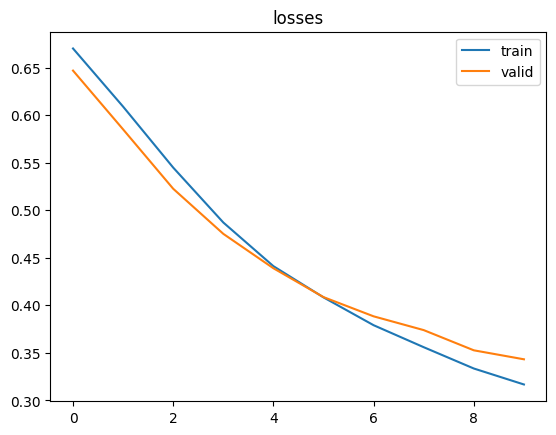

In [ ]:
import matplotlib.pyplot as plt

plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

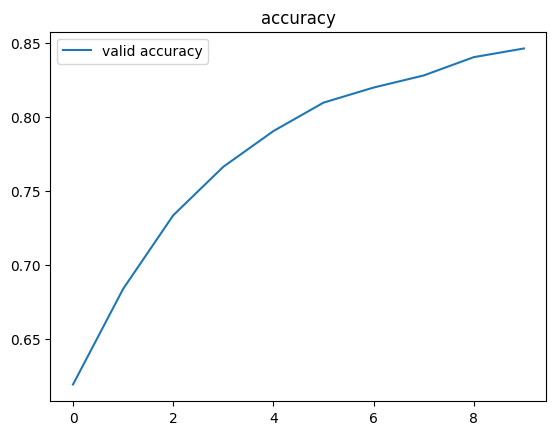

In [ ]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = trainer.evaluate(test_dataloader)

In [ ]:
print(f"Test loss {test_loss}, Test accuracy: {test_acc}")

Test loss 0.6478420666285923, Test accuracy: 0.75


## Get your hands dirty

Try to play a bit with the architecture, changing some hyperparameters, maybe adding more layers or changing the hidden size.

In [ ]:
"""
my_sentiment_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    ...
    num_classes=2,
    padding_index=padding_idx,
    device=device
)
"""

'\nmy_sentiment_tagger = BiLSTMModel(\n    vocabulary_length=len(vocabulary),\n    ...\n    num_classes=2,\n    padding_index=padding_idx,\n    device=device\n)\n'